In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,recall_score ,accuracy_score,precision_score, roc_auc_score

# Загрузка данных
df = pd.read_csv("data/cleaned_data.csv")

# Разделение признаков на числовые и категориальные
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [3]:
def replace_unknowns_in_categorical(df):
    categorical_cols = df.select_dtypes(include=['object']).columns  # Выбираем все категориальные колонки
    
    for col in categorical_cols:
        value_counts = df[col][df[col] != "unknown"].value_counts(normalize=True)  # Считаем пропорции без "unknown"
        
        if not value_counts.empty:  # Проверяем, есть ли нормальные категории
            df.loc[df[col] == "unknown", col] = np.random.choice(value_counts.index, 
                                                                  size=(df[col] == "unknown").sum(), 
                                                                  p=value_counts.values)
    return df

df = replace_unknowns_in_categorical(df)

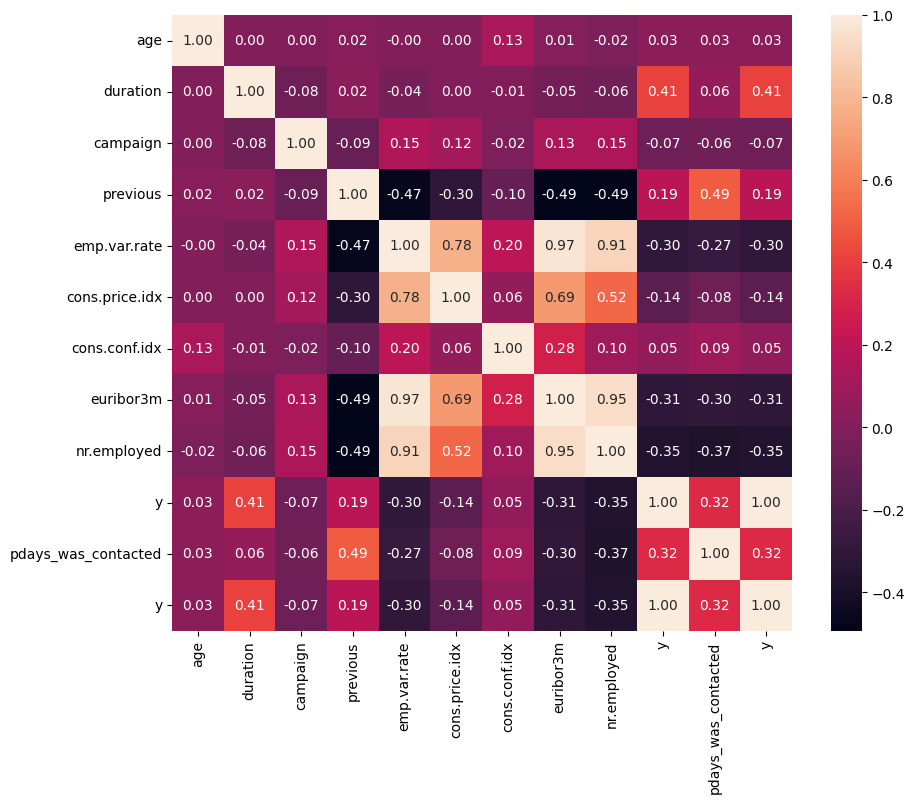

In [4]:
#corr matrix only for numberical and y

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features + ['y']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

In [5]:
# Разделение данных
X = df.drop(columns=['y'])
y = df['y']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Стандартизация числовых колонок (только по train)
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [8]:
cat_cols = X_train.select_dtypes(include=["object"]).columns
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

In [9]:
X_train_cat = pd.DataFrame(X_train_cat, columns=encoder.get_feature_names_out(cat_cols), index=X_train.index).sort_index().reset_index(drop=True)
X_test_cat = pd.DataFrame(X_test_cat, columns=encoder.get_feature_names_out(cat_cols), index=X_test.index).sort_index().reset_index(drop=True)

In [10]:
# Объединяем обратно
X_train = X_train.drop(columns=cat_cols).reset_index(drop=True)
X_test = X_test.drop(columns=cat_cols).reset_index(drop=True)

In [11]:
X_train = pd.concat([X_train, X_train_cat], axis=1)
X_test = pd.concat([X_test, X_test_cat], axis=1)

In [12]:
X_train

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_was_contacted,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-1.058427,0.235463,0.387151,-0.396498,0.838815,0.589534,-0.470932,0.771196,0.843413,-0.195698,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.954767,-0.324209,2.147042,-0.396498,0.838815,1.534740,-0.276368,0.716413,0.843413,-0.195698,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.058427,-0.712870,0.973782,-0.396498,0.838815,-0.229530,0.955866,0.773502,0.843413,-0.195698,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.483229,-0.547041,-0.786110,-0.396498,0.647683,0.720860,0.891011,0.714107,0.330793,-0.195698,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.003897,0.919507,-0.786110,-0.396498,-1.199927,-1.181648,-1.227566,-1.343979,-0.939011,-0.195698,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32935,-0.579095,-0.728417,-0.199479,-0.396498,0.647683,0.720860,0.891011,0.712377,0.330793,-0.195698,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32936,-1.058427,-0.624774,-0.786110,-0.396498,0.838815,1.534740,-0.276368,0.772349,0.843413,-0.195698,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32937,2.967961,0.048906,-0.199479,2.522081,-2.219298,-1.979976,2.944735,-1.653643,-2.066498,-0.195698,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32938,-0.003897,0.282103,-0.199479,-0.396498,0.647683,0.720860,0.891011,0.711800,0.330793,-0.195698,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
#smote model
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __init__


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [15]:
models = {
    "Logistic Regression": (LogisticRegression(), {
        "C": [0.01, 0.1, 1, 10],
        "max_iter": [100, 200, 300]
    }),
    "Random Forest": (RandomForestClassifier(), {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20]
    }),
    "KNN": (KNeighborsClassifier(), {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"]
    })
}

# Обучение и тестирование моделей
for name, (model, params) in models.items():

    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print(f"\n{name}:")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression:
Best Params: {'C': 0.01, 'max_iter': 100}
Accuracy: 0.8551
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7265
           1       0.85      0.87      0.86      7265

    accuracy                           0.86     14530
   macro avg       0.86      0.86      0.86     14530
weighted avg       0.86      0.86      0.86     14530


Random Forest:
Best Params: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.9359
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      7265
           1       0.95      0.92      0.93      7265

    accuracy                           0.94     14530
   macro avg       0.94      0.94      0.94     14530
weighted avg       0.94      0.94      0.94     14530


KNN:
Best Params: {'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.8137
              precision    recall  f1-score   support

           0       0.79      0.86      0.82  